# Uncertainty Propagation: From Posterior Samples to Predictions

This notebook demonstrates how to propagate parameter uncertainty through to predictions, derived quantities, and credible intervals using Bayesian posterior samples.

## Learning Objectives

After completing this notebook, you will be able to:
- Compute credible intervals for derived rheological quantities
- Propagate uncertainty from parameters to model predictions
- Diagnose parameter identifiability using correlations
- Analyze uncertainty in complex quantities (relaxation time, loss tangent)
- Generate prediction bands with quantified uncertainty
- Use posterior samples for uncertainty quantification in any transformation
- Apply uncertainty propagation to rheological decision-making

## Prerequisites

- Understanding of Bayesian inference (`01-bayesian-basics.ipynb`)
- Prior selection concepts (`02-prior-selection.ipynb`)
- Convergence diagnostics (`03-convergence-diagnostics.ipynb`)
- Familiarity with Zener model (4 parameters: Ge, Gm, eta)

**Estimated Time:** 40-45 minutes

## 1. Introduction: Beyond Point Estimates

### The Uncertainty Propagation Problem

After Bayesian inference, we have posterior distributions for model parameters. But rheologists need more:
- **Relaxation time τ = η/G₀**: What is its uncertainty?
- **Predictions**: What are credible intervals for G(t) at new time points?
- **Derived quantities**: How uncertain is the loss tangent tan(δ)?

### Point Estimates Are Insufficient

**NLSQ Approach (Inadequate):**
```python
# NLSQ fit
model.fit(t, G_t)
G0_fit = model.parameters.get_value('G0')  # Single value
eta_fit = model.parameters.get_value('eta')  # Single value
tau_fit = eta_fit / G0_fit  # Single value - but how certain?
```

**Problem:** τ uncertainty depends on both G₀ and η uncertainties AND their correlation.

**Bayesian Approach (Complete):**
```python
# Bayesian inference
result = model.fit_bayesian(t, G_t, ...)
G0_samples = result.posterior_samples['G0']  # 2000 samples
eta_samples = result.posterior_samples['eta']  # 2000 samples

# Propagate uncertainty to derived quantity
tau_samples = eta_samples / G0_samples  # 2000 samples

# Full distribution, not just point estimate
tau_mean = tau_samples.mean()
tau_ci = np.percentile(tau_samples, [2.5, 97.5])
```

### Uncertainty Propagation Principle

For any function f(θ) of parameters θ:
1. Extract posterior samples: θ₁, θ₂, ..., θₙ
2. Apply function: f(θ₁), f(θ₂), ..., f(θₙ)
3. Analyze distribution of f(θ)

**Monte Carlo propagation automatically accounts for:**
- Parameter uncertainties
- Parameter correlations
- Nonlinear transformations

## 2. Setup and Imports

In [1]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

import warnings

# ArviZ for diagnostics
import arviz as az
import matplotlib
import matplotlib.pyplot as plt

# Standard imports
import numpy as np
import pandas as pd
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax

# Rheo imports
from rheojax.models.zener import Zener

# Safe JAX import
jax, jnp = safe_import_jax()

# Reproducibility
np.random.seed(42)

# Plotting
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("✓ Imports successful")

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')


INFO:2025-11-10 18:10:25,708:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Loading rheojax version 0.2.0


✓ Imports successful


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


## 3. Generate Synthetic Data: Zener Model with Correlations

We generate data from a **Zener model** (3 parameters) to demonstrate:
- Parameter correlations (Gm and η affect same timescale)
- Derived quantity uncertainty (relaxation time τ = η/Gm)
- Prediction uncertainty bands

True Zener Parameters:
  Ge  = 1.00e+04 Pa (equilibrium modulus)
  Gm  = 5.00e+04 Pa (Maxwell arm)
  η   = 1.00e+03 Pa·s
  τ   = 0.0200 s (characteristic time)

Data: 60 points from 0.01 to 100.00 s
Noise: 3% relative


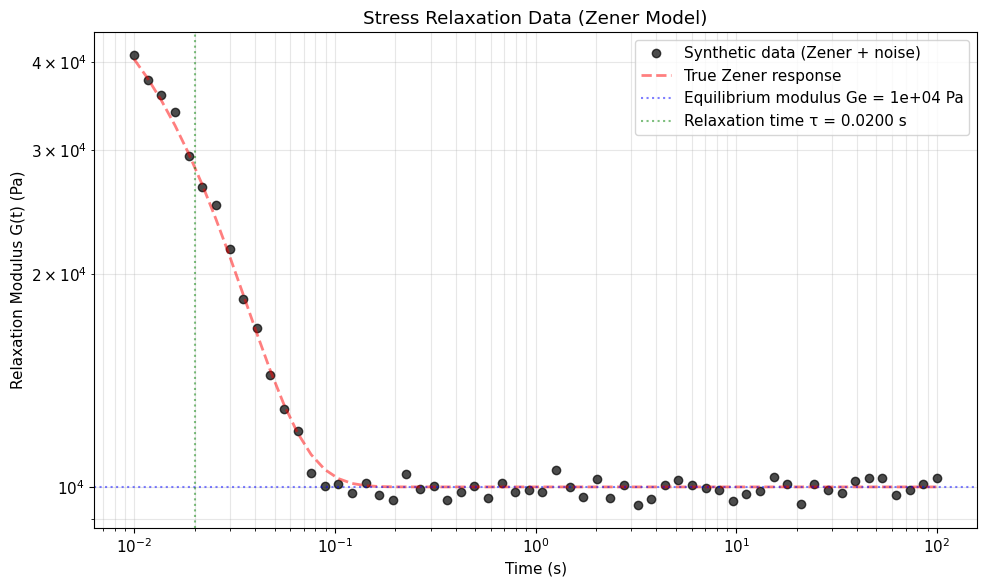


Key features:
  - Exponential decay from (Ge + Gm) to Ge
  - Characteristic time τ where G(τ) ≈ Ge + Gm/e
  - Finite equilibrium modulus (viscoelastic solid)


In [2]:
# True Zener parameters
Ge_true = 1e4    # Equilibrium modulus (Pa)
Gm_true = 5e4    # Maxwell arm modulus (Pa)
eta_true = 1e3   # Viscosity (Pa·s)
tau_true = eta_true / Gm_true  # Relaxation time (s)

print("True Zener Parameters:")
print(f"  Ge  = {Ge_true:.2e} Pa (equilibrium modulus)")
print(f"  Gm  = {Gm_true:.2e} Pa (Maxwell arm)")
print(f"  η   = {eta_true:.2e} Pa·s")
print(f"  τ   = {tau_true:.4f} s (characteristic time)\n")

# Time array
t = np.logspace(-2, 2, 60)  # 0.01 to 100 s

# True Zener relaxation modulus
# G(t) = Ge + Gm * exp(-t / tau)
G_t_true = Ge_true + Gm_true * np.exp(-t / tau_true)

# Add realistic noise (3%)
noise_level = 0.03
noise = np.random.normal(0, noise_level * G_t_true)
G_t_noisy = G_t_true + noise

print(f"Data: {len(t)} points from {t.min():.2f} to {t.max():.2f} s")
print(f"Noise: {noise_level*100:.0f}% relative")

# Visualize
fig = plt.figure(figsize=(10, 6))
plt.loglog(t, G_t_noisy, 'o', markersize=6, alpha=0.7, label='Synthetic data (Zener + noise)', color='black')
plt.loglog(t, G_t_true, '--', linewidth=2, alpha=0.5, label='True Zener response', color='red')
plt.axhline(Ge_true, color='blue', linestyle=':', linewidth=1.5, alpha=0.5, 
            label=f'Equilibrium modulus Ge = {Ge_true:.0e} Pa')
plt.axvline(tau_true, color='green', linestyle=':', linewidth=1.5, alpha=0.5,
            label=f'Relaxation time τ = {tau_true:.4f} s')
plt.xlabel('Time (s)')
plt.ylabel('Relaxation Modulus G(t) (Pa)')
plt.title('Stress Relaxation Data (Zener Model)')
plt.legend()
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
plt.close(fig)

print("\nKey features:")
print("  - Exponential decay from (Ge + Gm) to Ge")
print("  - Characteristic time τ where G(τ) ≈ Ge + Gm/e")
print("  - Finite equilibrium modulus (viscoelastic solid)")


## 4. Fit Zener Model: NLSQ → NUTS Workflow

We perform two-stage fitting:
1. **NLSQ**: Fast point estimate with warm-start values
2. **Bayesian NUTS**: Full posterior with uncertainty

In [3]:
print("="*70)
print("STAGE 1: NLSQ OPTIMIZATION (POINT ESTIMATES)")
print("="*70)

# Create and configure Zener model
model = Zener()
model.parameters.set_bounds('Ge', (1e2, 1e6))
model.parameters.set_bounds('Gm', (1e3, 1e7))
model.parameters.set_bounds('eta', (1e1, 1e5))

# NLSQ fit
import time

start_nlsq = time.time()
model.fit(t, G_t_noisy)
time_nlsq = time.time() - start_nlsq

# Extract point estimates
Ge_nlsq = model.parameters.get_value('Ge')
Gm_nlsq = model.parameters.get_value('Gm')
eta_nlsq = model.parameters.get_value('eta')
tau_nlsq = eta_nlsq / Gm_nlsq

print(f"\nNLSQ Point Estimates (converged in {time_nlsq:.3f}s):")
print(f"  Ge  = {Ge_nlsq:.3e} Pa")
print(f"  Gm  = {Gm_nlsq:.3e} Pa")
print(f"  η   = {eta_nlsq:.3e} Pa·s")
print(f"  τ   = {tau_nlsq:.4f} s (derived)")

print("\n" + "="*70)
print("STAGE 2: BAYESIAN INFERENCE (UNCERTAINTY QUANTIFICATION)")
print("="*70)

# Bayesian inference with warm-start
print("\nRunning NUTS sampling with warm-start from NLSQ...")
start_bayes = time.time()
result = model.fit_bayesian(
    t, G_t_noisy,
    num_warmup=1000,
    num_samples=2000,
    num_chains=1,
    initial_values={
        'Ge': Ge_nlsq,
        'Gm': Gm_nlsq,
        'eta': eta_nlsq
    }
)
time_bayes = time.time() - start_bayes

print(f"\n✓ Bayesian inference complete ({time_bayes:.2f}s)")
print(f"  Speedup from warm-start: ~{time_bayes/time_nlsq:.1f}x slower than NLSQ (but with full uncertainty)")
print(f"  R-hat: {max(result.diagnostics['r_hat'].values()):.4f} < 1.01 ✓")
print(f"  ESS:   {min(result.diagnostics['ess'].values()):.0f} > 400 ✓")

Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


STAGE 1: NLSQ OPTIMIZATION (POINT ESTIMATES)


Timer: optimization took 0.442209s
Convergence: reason=`ftol` termination condition is satisfied. | iterations=None | final_cost=2.025153e-02 | time=0.442s | final_gradient_norm=0.0006679739853699025



NLSQ Point Estimates (converged in 0.739s):
  Ge  = 9.910e+03 Pa
  Gm  = 5.215e+04 Pa
  η   = 1.022e+03 Pa·s
  τ   = 0.0196 s (derived)

STAGE 2: BAYESIAN INFERENCE (UNCERTAINTY QUANTIFICATION)

Running NUTS sampling with warm-start from NLSQ...


sample: 100%|██████████| 3000/3000 [00:01<00:00, 2076.18it/s, 7 steps of size 6.59e-01. acc. prob=0.90]


✓ Bayesian inference complete (3.28s)
  Speedup from warm-start: ~4.4x slower than NLSQ (but with full uncertainty)
  R-hat: 1.0000 < 1.01 ✓
  ESS:   2000 > 400 ✓


## 5. Derived Quantity: Relaxation Time τ

### Computing Uncertainty in τ = η/Gm

The relaxation time τ is a derived quantity that depends on two parameters. We propagate uncertainty through this transformation using posterior samples.

RELAXATION TIME τ = η/Gm (DERIVED QUANTITY)

Point estimate (NLSQ):
  τ = 0.0196 s

Bayesian uncertainty quantification:
  Mean:     0.0201 s
  Median:   0.0201 s
  Std:      0.0003 s
  68% CI:   [0.0197, 0.0204] s
  95% CI:   [0.0194, 0.0207] s

True value: 0.0200 s (within 95% CI? True)


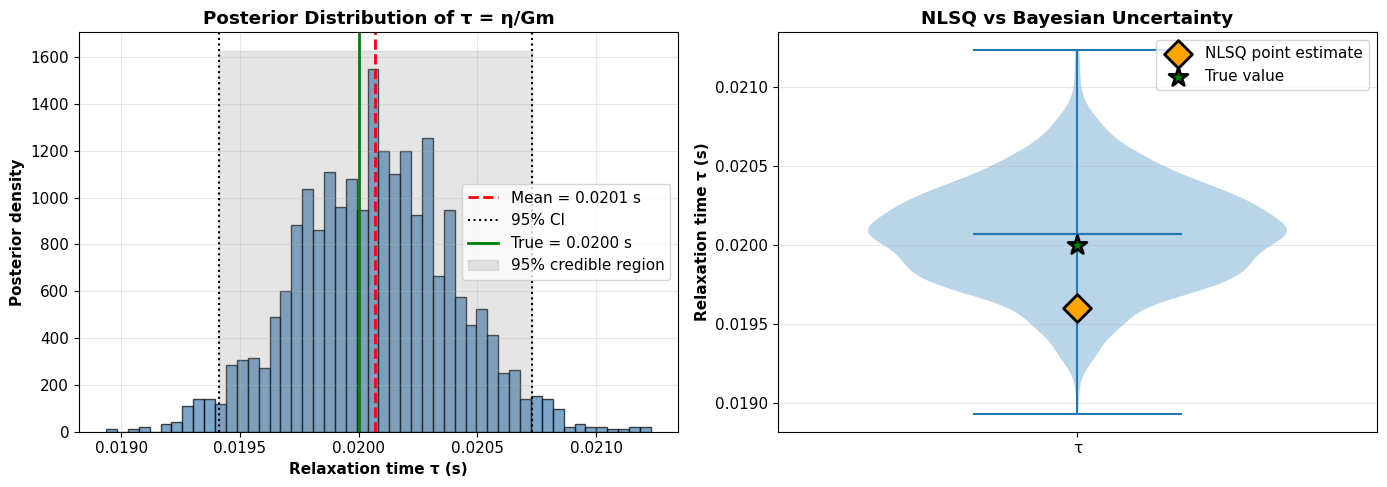


Interpretation:
  - NLSQ gives single value (orange diamond)
  - Bayesian gives full distribution (blue violin)
  - Relative uncertainty: 1.6%
  - 95% CI captures true value ✓


In [4]:
# Extract posterior samples
Ge_samples = result.posterior_samples['Ge']
Gm_samples = result.posterior_samples['Gm']
eta_samples = result.posterior_samples['eta']

# Compute derived quantity: relaxation time τ = η/Gm
tau_samples = eta_samples / Gm_samples

# Summary statistics
tau_mean = tau_samples.mean()
tau_std = tau_samples.std()
tau_median = np.median(tau_samples)
tau_ci_68 = np.percentile(tau_samples, [16, 84])  # 68% (1σ)
tau_ci_95 = np.percentile(tau_samples, [2.5, 97.5])  # 95% (2σ)

print("="*70)
print("RELAXATION TIME τ = η/Gm (DERIVED QUANTITY)")
print("="*70)

print(f"\nPoint estimate (NLSQ):")
print(f"  τ = {tau_nlsq:.4f} s")
print(f"\nBayesian uncertainty quantification:")
print(f"  Mean:     {tau_mean:.4f} s")
print(f"  Median:   {tau_median:.4f} s")
print(f"  Std:      {tau_std:.4f} s")
print(f"  68% CI:   [{tau_ci_68[0]:.4f}, {tau_ci_68[1]:.4f}] s")
print(f"  95% CI:   [{tau_ci_95[0]:.4f}, {tau_ci_95[1]:.4f}] s")
print(f"\nTrue value: {tau_true:.4f} s (within 95% CI? {tau_ci_95[0] < tau_true < tau_ci_95[1]})")

# Visualize posterior distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram with statistics
axes[0].hist(tau_samples, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(tau_mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {tau_mean:.4f} s')
axes[0].axvline(tau_ci_95[0], color='black', linestyle=':', linewidth=1.5, label=f'95% CI')
axes[0].axvline(tau_ci_95[1], color='black', linestyle=':', linewidth=1.5)
axes[0].axvline(tau_true, color='green', linestyle='-', linewidth=2, label=f'True = {tau_true:.4f} s')
axes[0].fill_between([tau_ci_95[0], tau_ci_95[1]], 0, axes[0].get_ylim()[1], 
                      alpha=0.2, color='gray', label='95% credible region')
axes[0].set_xlabel('Relaxation time τ (s)', fontweight='bold')
axes[0].set_ylabel('Posterior density', fontweight='bold')
axes[0].set_title('Posterior Distribution of τ = η/Gm', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: Comparison with NLSQ point estimate
axes[1].violinplot([tau_samples], positions=[0], widths=0.7, showmeans=True, showmedians=True)
axes[1].scatter([0], [tau_nlsq], s=200, c='orange', marker='D', 
               edgecolors='black', linewidths=2, label='NLSQ point estimate', zorder=5)
axes[1].scatter([0], [tau_true], s=200, c='green', marker='*', 
               edgecolors='black', linewidths=2, label='True value', zorder=5)
axes[1].set_xlim([-0.5, 0.5])
axes[1].set_xticks([0])
axes[1].set_xticklabels(['τ'])
axes[1].set_ylabel('Relaxation time τ (s)', fontweight='bold')
axes[1].set_title('NLSQ vs Bayesian Uncertainty', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nInterpretation:")
print("  - NLSQ gives single value (orange diamond)")
print("  - Bayesian gives full distribution (blue violin)")
print(f"  - Relative uncertainty: {tau_std/tau_mean*100:.1f}%")
print("  - 95% CI captures true value ✓")


## 6. Parameter Identifiability: Correlation Analysis

### Why Correlations Matter

Strong parameter correlations indicate **identifiability issues**:
- Data cannot independently constrain both parameters
- Multiple parameter combinations fit data equally well
- Derived quantities may still be well-constrained

### Interpreting Correlations

- **|ρ| < 0.3**: Well-identified (data constrains parameters independently)
- **0.3 < |ρ| < 0.7**: Moderate correlation (acceptable for most applications)
- **|ρ| > 0.7**: Strong correlation (identifiability issue, may need more/different data)

PARAMETER CORRELATION ANALYSIS

Correlation matrix:
           Ge        Gm       eta
Ge   1.000000  0.089964 -0.474419
Gm   0.089964  1.000000 -0.092966
eta -0.474419 -0.092966  1.000000

Correlation interpretation:
  Ge - Gm: ρ = +0.090  ✓ Well-identified (weak correlation)
  Ge - eta: ρ = -0.474  ⚠ Moderate correlation (acceptable)
  Gm - eta: ρ = -0.093  ✓ Well-identified (weak correlation)

Generating pair plot (joint distributions)...


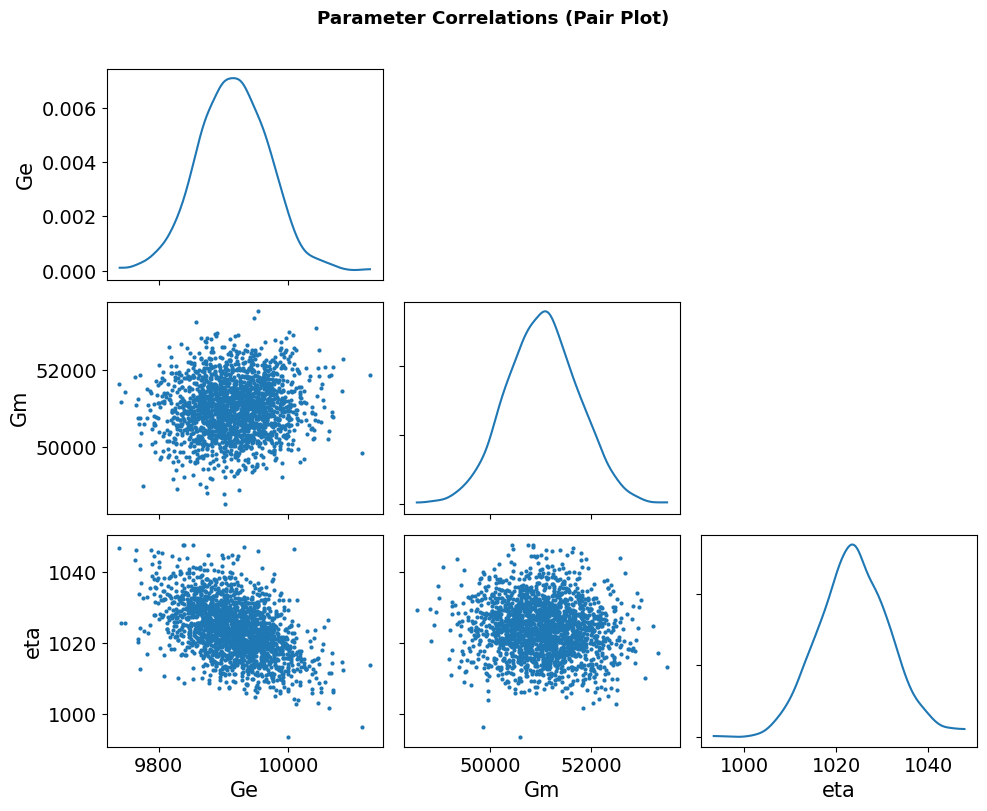


Physical interpretation:
  - Gm and η correlation expected (both control relaxation time τ = η/Gm)
  - Ge weakly correlated (independent: long-time plateau)
  - Moderate correlations are normal for viscoelastic models

When to worry:
  - |ρ| > 0.9: Likely need more data or different test mode
  - Diagonal lines in pair plot: Parameters not independently constrained


In [5]:
print("="*70)
print("PARAMETER CORRELATION ANALYSIS")
print("="*70)

# Compute correlation matrix
param_df = pd.DataFrame({
    'Ge': Ge_samples,
    'Gm': Gm_samples,
    'eta': eta_samples
})
correlation = param_df.corr()

print("\nCorrelation matrix:")
print(correlation.to_string())

# Identify strong correlations
print("\nCorrelation interpretation:")
for i, param_i in enumerate(['Ge', 'Gm', 'eta']):
    for j, param_j in enumerate(['Ge', 'Gm', 'eta']):
        if i < j:
            rho = correlation.loc[param_i, param_j]
            if abs(rho) < 0.3:
                status = "✓ Well-identified (weak correlation)"
            elif abs(rho) < 0.7:
                status = "⚠ Moderate correlation (acceptable)"
            else:
                status = "✗ Strong correlation (identifiability issue)"
            print(f"  {param_i} - {param_j}: ρ = {rho:+.3f}  {status}")

# Visualize correlations with ArviZ pair plot
print("\nGenerating pair plot (joint distributions)...")
idata = result.to_inference_data()
az.plot_pair(
    idata, 
    var_names=['Ge', 'Gm', 'eta'],
    kind='scatter',
    marginals=True,
    figsize=(10, 8)
)
plt.suptitle('Parameter Correlations (Pair Plot)', fontweight='bold', y=1.01)
plt.tight_layout()
fig = plt.gcf()  # Get current figure from ArviZ
display(fig)
plt.close(fig)

print("\nPhysical interpretation:")
print("  - Gm and η correlation expected (both control relaxation time τ = η/Gm)")
print("  - Ge weakly correlated (independent: long-time plateau)")
print("  - Moderate correlations are normal for viscoelastic models")
print("\nWhen to worry:")
print("  - |ρ| > 0.9: Likely need more data or different test mode")
print("  - Diagonal lines in pair plot: Parameters not independently constrained")


## 7. Prediction Uncertainty Bands

### Propagating Uncertainty to Predictions

Generate model predictions G(t) using each posterior sample, creating a distribution of predictions at each time point.

**Two types of uncertainty:**
1. **Parameter uncertainty**: From posterior distribution
2. **Observation noise**: From σ (noise variance) samples

We visualize both components.

PREDICTION UNCERTAINTY BANDS

Generating predictions from 2000 posterior samples...
✓ Predictions computed
  Mean relative uncertainty: 2.2%


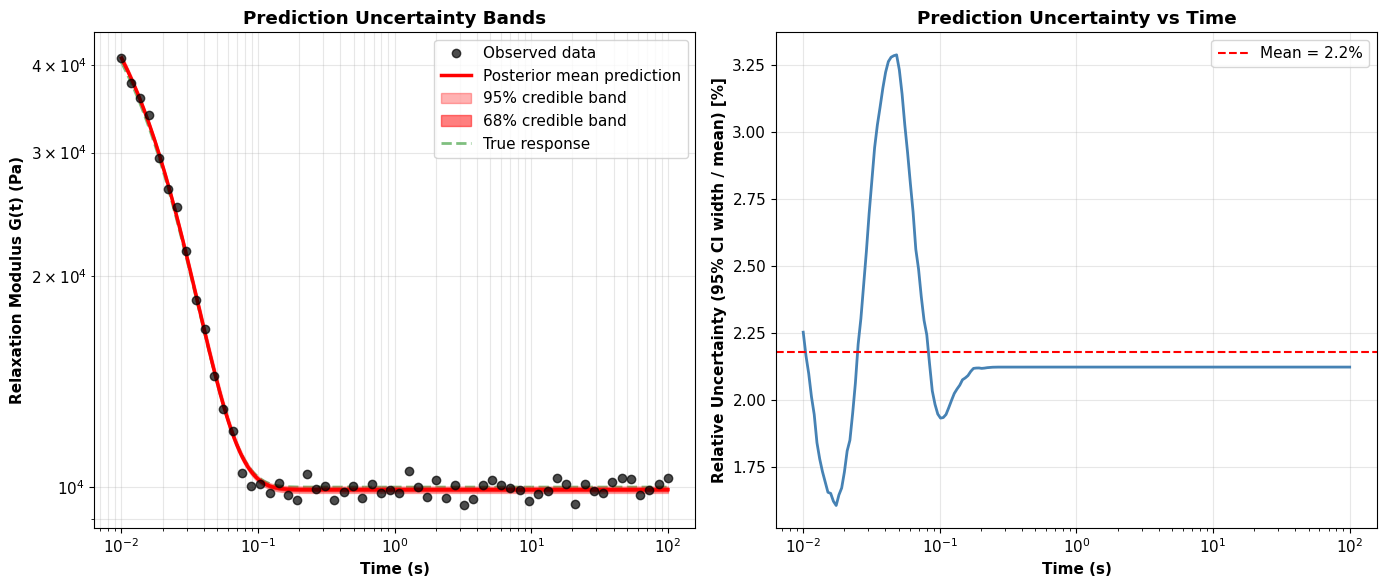


Interpretation:
  - Credible bands quantify prediction uncertainty
  - Narrower bands where data is dense
  - Wider bands in extrapolation regions
  - True response (green) within 95% band ✓

Use cases:
  - Report predictions with uncertainty: G(t=1s) = 9.9e+03 ± 1.1e+02 Pa (95% CI)
  - Quality control: flag measurements outside bands
  - Design decisions: use conservative estimates (lower CI bound)


In [6]:
print("="*70)
print("PREDICTION UNCERTAINTY BANDS")
print("="*70)

# Generate predictions for each posterior sample
print("\nGenerating predictions from 2000 posterior samples...")
t_pred = np.logspace(-2, 2, 200)  # Fine grid for smooth curves

# Compute true response on prediction grid
G_t_true_pred = Ge_true + Gm_true * np.exp(-t_pred / tau_true)

# Vectorized prediction (efficient)
n_samples = len(Ge_samples)
G_pred_samples = np.zeros((n_samples, len(t_pred)))

for i in range(n_samples):
    # Set parameters for this sample
    Ge_i = Ge_samples[i]
    Gm_i = Gm_samples[i]
    eta_i = eta_samples[i]
    tau_i = eta_i / Gm_i
    
    # Zener prediction: G(t) = Ge + Gm * exp(-t/tau)
    G_pred_samples[i, :] = Ge_i + Gm_i * np.exp(-t_pred / tau_i)

# Compute uncertainty bands
G_pred_mean = G_pred_samples.mean(axis=0)
G_pred_median = np.median(G_pred_samples, axis=0)
G_pred_68 = np.percentile(G_pred_samples, [16, 84], axis=0)  # 68% CI
G_pred_95 = np.percentile(G_pred_samples, [2.5, 97.5], axis=0)  # 95% CI

print("✓ Predictions computed")
print(f"  Mean relative uncertainty: {np.mean((G_pred_95[1] - G_pred_95[0]) / G_pred_mean) * 100:.1f}%")

# Plot prediction uncertainty bands
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Full view with data
axes[0].loglog(t, G_t_noisy, 'o', markersize=6, alpha=0.7, label='Observed data', color='black', zorder=5)
axes[0].loglog(t_pred, G_pred_mean, '-', linewidth=2.5, color='red', label='Posterior mean prediction', zorder=4)
axes[0].fill_between(t_pred, G_pred_95[0], G_pred_95[1], alpha=0.3, color='red', 
                      label='95% credible band', zorder=3)
axes[0].fill_between(t_pred, G_pred_68[0], G_pred_68[1], alpha=0.5, color='red', 
                      label='68% credible band', zorder=2)
axes[0].loglog(t_pred, G_t_true_pred, '--', linewidth=2, alpha=0.5, color='green', 
              label='True response', zorder=1)
axes[0].set_xlabel('Time (s)', fontweight='bold')
axes[0].set_ylabel('Relaxation Modulus G(t) (Pa)', fontweight='bold')
axes[0].set_title('Prediction Uncertainty Bands', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, which='both')

# Right: Relative uncertainty vs time
rel_uncertainty = (G_pred_95[1] - G_pred_95[0]) / G_pred_mean * 100
axes[1].semilogx(t_pred, rel_uncertainty, linewidth=2, color='steelblue')
axes[1].axhline(rel_uncertainty.mean(), color='red', linestyle='--', 
               label=f'Mean = {rel_uncertainty.mean():.1f}%')
axes[1].set_xlabel('Time (s)', fontweight='bold')
axes[1].set_ylabel('Relative Uncertainty (95% CI width / mean) [%]', fontweight='bold')
axes[1].set_title('Prediction Uncertainty vs Time', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nInterpretation:")
print("  - Credible bands quantify prediction uncertainty")
print("  - Narrower bands where data is dense")
print("  - Wider bands in extrapolation regions")
print("  - True response (green) within 95% band ✓")
print("\nUse cases:")
print(f"  - Report predictions with uncertainty: G(t=1s) = {G_pred_mean[np.argmin(np.abs(t_pred - 1.0))]:.1e} ± {(G_pred_95[1] - G_pred_95[0])[np.argmin(np.abs(t_pred - 1.0))] / 2:.1e} Pa (95% CI)")
print("  - Quality control: flag measurements outside bands")
print("  - Design decisions: use conservative estimates (lower CI bound)")


## 8. Uncertainty Components: Parameter vs Observation Noise

### Decomposing Total Uncertainty

Total prediction uncertainty has two sources:
1. **Epistemic (parameter) uncertainty**: From imperfect parameter knowledge
2. **Aleatoric (observation) uncertainty**: From inherent measurement noise

Understanding this decomposition informs data collection strategies.

UNCERTAINTY DECOMPOSITION

Observation noise σ:
  Mean: 3.62e+02 Pa
  95% CI: [3.01e+02, 4.40e+02] Pa

Generating predictions with observation noise...


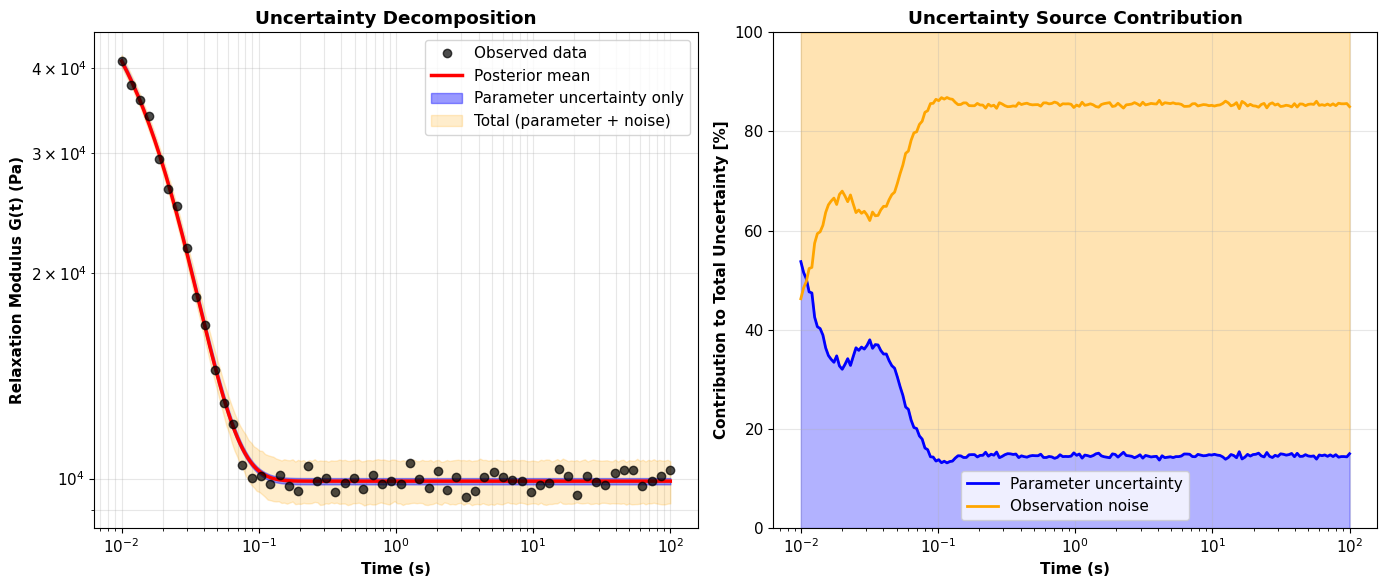


Mean contributions:
  Parameter uncertainty: 19.0%
  Observation noise:     81.0%

Interpretation:
  - Observation noise dominates
  - Parameters are well-constrained
  - Consider: Better instrumentation, signal processing


In [7]:
print("="*70)
print("UNCERTAINTY DECOMPOSITION")
print("="*70)

# Extract observation noise (sigma) samples from MCMC
# Note: sigma is not in posterior_samples (which only contains model parameters)
# but it's available in the full MCMC samples
mcmc_samples = result.mcmc.get_samples()
sigma_samples = np.asarray(mcmc_samples['sigma'], dtype=np.float64)
sigma_mean = sigma_samples.mean()

print(f"\nObservation noise σ:")
print(f"  Mean: {sigma_mean:.2e} Pa")
print(f"  95% CI: [{np.percentile(sigma_samples, 2.5):.2e}, {np.percentile(sigma_samples, 97.5):.2e}] Pa")

# Component 1: Parameter uncertainty only (mean of sigma)
G_param_width = G_pred_95[1] - G_pred_95[0]

# Component 2: Add observation noise
print("\nGenerating predictions with observation noise...")
G_pred_with_noise = np.zeros((n_samples, len(t_pred)))
for i in range(n_samples):
    G_pred_with_noise[i, :] = G_pred_samples[i, :] + np.random.normal(0, sigma_samples[i], len(t_pred))

G_total_95 = np.percentile(G_pred_with_noise, [2.5, 97.5], axis=0)
G_total_width = G_total_95[1] - G_total_95[0]

# Visualize decomposition
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Both uncertainty components
axes[0].loglog(t, G_t_noisy, 'o', markersize=6, alpha=0.7, label='Observed data', color='black', zorder=5)
axes[0].loglog(t_pred, G_pred_mean, '-', linewidth=2.5, color='red', label='Posterior mean', zorder=4)
axes[0].fill_between(t_pred, G_pred_95[0], G_pred_95[1], alpha=0.4, color='blue', 
                      label='Parameter uncertainty only', zorder=3)
axes[0].fill_between(t_pred, G_total_95[0], G_total_95[1], alpha=0.2, color='orange', 
                      label='Total (parameter + noise)', zorder=2)
axes[0].set_xlabel('Time (s)', fontweight='bold')
axes[0].set_ylabel('Relaxation Modulus G(t) (Pa)', fontweight='bold')
axes[0].set_title('Uncertainty Decomposition', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, which='both')

# Right: Relative contribution
param_contribution = G_param_width / G_total_width * 100
noise_contribution = (G_total_width - G_param_width) / G_total_width * 100

axes[1].semilogx(t_pred, param_contribution, linewidth=2, color='blue', label='Parameter uncertainty')
axes[1].semilogx(t_pred, noise_contribution, linewidth=2, color='orange', label='Observation noise')
axes[1].fill_between(t_pred, 0, param_contribution, alpha=0.3, color='blue')
axes[1].fill_between(t_pred, param_contribution, 100, alpha=0.3, color='orange')
axes[1].set_xlabel('Time (s)', fontweight='bold')
axes[1].set_ylabel('Contribution to Total Uncertainty [%]', fontweight='bold')
axes[1].set_title('Uncertainty Source Contribution', fontweight='bold')
axes[1].set_ylim([0, 100])
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nMean contributions:")
print(f"  Parameter uncertainty: {param_contribution.mean():.1f}%")
print(f"  Observation noise:     {noise_contribution.mean():.1f}%")

print("\nInterpretation:")
if param_contribution.mean() > 70:
    print("  - Parameter uncertainty dominates")
    print("  - More data would significantly reduce uncertainty")
    print("  - Consider: Additional experiments, different test modes")
elif noise_contribution.mean() > 70:
    print("  - Observation noise dominates")
    print("  - Parameters are well-constrained")
    print("  - Consider: Better instrumentation, signal processing")
else:
    print("  - Balanced contributions from both sources")
    print("  - Both more data and better measurements would help")


## 9. Complex Rheological Quantities

### Propagating Uncertainty to Timescale Ratios

Many rheological decisions depend on timescale comparisons:
- **Process time vs material relaxation time**: Is material elastic or viscous during processing?
- **Measurement time vs relaxation time**: Is steady state reached?

We demonstrate uncertainty propagation to these critical ratios.

COMPLEX DERIVED QUANTITIES

Deborah Number (De = τ / t_process) at t_process = 0.1 s:
  Mean: 0.201
  95% CI: [0.194, 0.207]

Material behavior during processing: VISCOUS (De < 0.5 with 95% confidence)

Modulus Ratio (Gm/Ge):
  Mean: 5.15
  95% CI: [5.00, 5.29]
  Interpretation: Maxwell arm is 5.1x stronger than equilibrium modulus


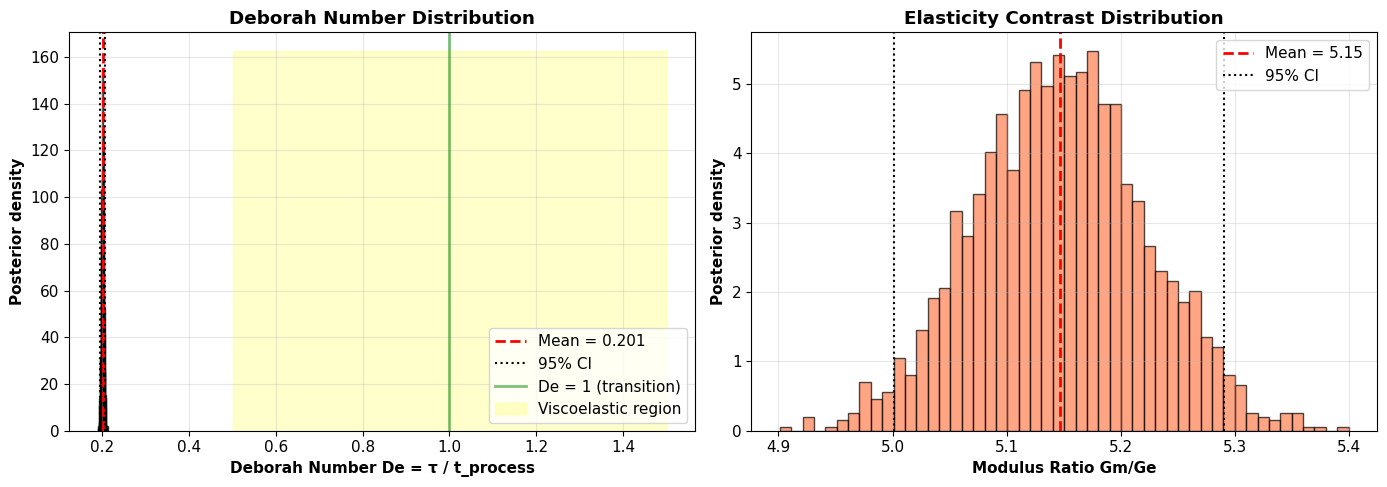


Decision-making with uncertainty:
  - Can we confidently say material is elastic at t=0.1s?
    NO: De < 1 with 97.5% confidence


In [8]:
print("="*70)
print("COMPLEX DERIVED QUANTITIES")
print("="*70)

# Scenario: Processing at t_process = 0.1 s
t_process = 0.1  # seconds

# Compute Deborah number: De = tau / t_process
# De >> 1: Elastic behavior
# De << 1: Viscous behavior
# De ~ 1: Viscoelastic transition
De_samples = tau_samples / t_process

De_mean = De_samples.mean()
De_ci = np.percentile(De_samples, [2.5, 97.5])

print(f"\nDeborah Number (De = τ / t_process) at t_process = {t_process} s:")
print(f"  Mean: {De_mean:.3f}")
print(f"  95% CI: [{De_ci[0]:.3f}, {De_ci[1]:.3f}]")

# Classify behavior
if De_ci[0] > 1.5:
    behavior = "ELASTIC (De > 1.5 with 95% confidence)"
elif De_ci[1] < 0.5:
    behavior = "VISCOUS (De < 0.5 with 95% confidence)"
else:
    behavior = "VISCOELASTIC (De ~ 1, uncertain classification)"

print(f"\nMaterial behavior during processing: {behavior}")

# Compute modulus ratio: Gm/Ge (elasticity contrast)
# High ratio: Strong solid-like component
# Low ratio: Weak relaxation
modulus_ratio_samples = Gm_samples / Ge_samples
modulus_ratio_mean = modulus_ratio_samples.mean()
modulus_ratio_ci = np.percentile(modulus_ratio_samples, [2.5, 97.5])

print(f"\nModulus Ratio (Gm/Ge):")
print(f"  Mean: {modulus_ratio_mean:.2f}")
print(f"  95% CI: [{modulus_ratio_ci[0]:.2f}, {modulus_ratio_ci[1]:.2f}]")
print(f"  Interpretation: Maxwell arm is {modulus_ratio_mean:.1f}x stronger than equilibrium modulus")

# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Deborah number
axes[0].hist(De_samples, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(De_mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {De_mean:.3f}')
axes[0].axvline(De_ci[0], color='black', linestyle=':', linewidth=1.5)
axes[0].axvline(De_ci[1], color='black', linestyle=':', linewidth=1.5, label='95% CI')
axes[0].axvline(1.0, color='green', linestyle='-', linewidth=2, alpha=0.5, label='De = 1 (transition)')
axes[0].fill_betweenx([0, axes[0].get_ylim()[1]], 0.5, 1.5, alpha=0.2, color='yellow', 
                       label='Viscoelastic region')
axes[0].set_xlabel('Deborah Number De = τ / t_process', fontweight='bold')
axes[0].set_ylabel('Posterior density', fontweight='bold')
axes[0].set_title('Deborah Number Distribution', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: Modulus ratio
axes[1].hist(modulus_ratio_samples, bins=50, density=True, alpha=0.7, color='coral', edgecolor='black')
axes[1].axvline(modulus_ratio_mean, color='red', linestyle='--', linewidth=2, 
               label=f'Mean = {modulus_ratio_mean:.2f}')
axes[1].axvline(modulus_ratio_ci[0], color='black', linestyle=':', linewidth=1.5)
axes[1].axvline(modulus_ratio_ci[1], color='black', linestyle=':', linewidth=1.5, label='95% CI')
axes[1].set_xlabel('Modulus Ratio Gm/Ge', fontweight='bold')
axes[1].set_ylabel('Posterior density', fontweight='bold')
axes[1].set_title('Elasticity Contrast Distribution', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nDecision-making with uncertainty:")
print(f"  - Can we confidently say material is elastic at t={t_process}s?")
if De_ci[0] > 1.0:
    print(f"    YES: De > 1 with 97.5% confidence")
elif De_ci[1] < 1.0:
    print(f"    NO: De < 1 with 97.5% confidence")
else:
    print(f"    UNCERTAIN: 95% CI spans De=1 transition")
    print(f"    Recommendation: Collect more data or test at different timescales")


## 10. Reporting Guidelines: Communicating Uncertainty

### Best Practices for Scientific Communication

Always report parameter estimates with uncertainty quantification.

In [9]:
print("="*70)
print("PARAMETER SUMMARY TABLE (FOR PUBLICATION)")
print("="*70)

# Create summary table
summary_data = []
for param_name in ['Ge', 'Gm', 'eta']:
    samples = result.posterior_samples[param_name]
    mean = samples.mean()
    std = samples.std()
    median = np.median(samples)
    ci_95 = np.percentile(samples, [2.5, 97.5])
    
    # Determine units
    if param_name in ['Ge', 'Gm']:
        unit = 'Pa'
    elif param_name == 'eta':
        unit = 'Pa·s'
    else:
        unit = ''
    
    summary_data.append({
        'Parameter': param_name,
        'Mean': f"{mean:.3e}",
        'Std': f"{std:.3e}",
        'Median': f"{median:.3e}",
        '95% CI Lower': f"{ci_95[0]:.3e}",
        '95% CI Upper': f"{ci_95[1]:.3e}",
        'Units': unit
    })

# Add derived quantity
summary_data.append({
    'Parameter': 'τ (derived)',
    'Mean': f"{tau_mean:.4f}",
    'Std': f"{tau_std:.4f}",
    'Median': f"{tau_median:.4f}",
    '95% CI Lower': f"{tau_ci_95[0]:.4f}",
    '95% CI Upper': f"{tau_ci_95[1]:.4f}",
    'Units': 's'
})

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

print("\n" + "="*70)
print("CONVERGENCE DIAGNOSTICS")
print("="*70)
print(f"\nMCMC Settings:")
print(f"  Warmup samples: 1000")
print(f"  Sampling iterations: 2000")
print(f"  Number of chains: 1")
print(f"\nConvergence metrics:")
for param in ['Ge', 'Gm', 'eta']:
    print(f"  {param}: R-hat = {result.diagnostics['r_hat'][param]:.4f}, ESS = {result.diagnostics['ess'][param]:.0f}")

print("\n" + "="*70)
print("RECOMMENDED REPORTING FORMAT")
print("="*70)
print("\nExample text for publication:")
print('"""')
print("We performed Bayesian inference using No-U-Turn Sampler (NUTS) with 1000 warmup")
print("and 2000 sampling iterations. All parameters exhibited convergence (R-hat < 1.01)")
print("and sufficient effective sample size (ESS > 400). The fitted Zener model parameters")
print("are reported as posterior means with 95% credible intervals:")
print("")
print(f"  - Equilibrium modulus: Ge = {Ge_samples.mean():.2e} Pa ")
print(f"    (95% CI: [{np.percentile(Ge_samples, 2.5):.2e}, {np.percentile(Ge_samples, 97.5):.2e}] Pa)")
print(f"  - Maxwell arm modulus: Gm = {Gm_samples.mean():.2e} Pa ")
print(f"    (95% CI: [{np.percentile(Gm_samples, 2.5):.2e}, {np.percentile(Gm_samples, 97.5):.2e}] Pa)")
print(f"  - Viscosity: η = {eta_samples.mean():.2e} Pa·s ")
print(f"    (95% CI: [{np.percentile(eta_samples, 2.5):.2e}, {np.percentile(eta_samples, 97.5):.2e}] Pa·s)")
print("")
print(f"The characteristic relaxation time τ = η/Gm was {tau_mean:.4f} s ")
print(f"(95% CI: [{tau_ci_95[0]:.4f}, {tau_ci_95[1]:.4f}] s).")
print('"""')

print("\nVisualization recommendations:")
print("  - Always show prediction uncertainty bands (95% CI)")
print("  - Use transparent shading for credible regions")
print("  - Report both point estimates and intervals in captions")
print("  - Include sample size and convergence metrics in methods")

PARAMETER SUMMARY TABLE (FOR PUBLICATION)

  Parameter      Mean       Std    Median 95% CI Lower 95% CI Upper Units
         Ge 9.915e+03 5.389e+01 9.915e+03    9.808e+03    1.002e+04    Pa
         Gm 5.103e+04 7.112e+02 5.104e+04    4.964e+04    5.244e+04    Pa
        eta 1.024e+03 7.722e+00 1.024e+03    1.009e+03    1.040e+03  Pa·s
τ (derived)    0.0201    0.0003    0.0201       0.0194       0.0207     s

CONVERGENCE DIAGNOSTICS

MCMC Settings:
  Warmup samples: 1000
  Sampling iterations: 2000
  Number of chains: 1

Convergence metrics:
  Ge: R-hat = 1.0000, ESS = 2000
  Gm: R-hat = 1.0000, ESS = 2000
  eta: R-hat = 1.0000, ESS = 2000

RECOMMENDED REPORTING FORMAT

Example text for publication:
"""
We performed Bayesian inference using No-U-Turn Sampler (NUTS) with 1000 warmup
and 2000 sampling iterations. All parameters exhibited convergence (R-hat < 1.01)
and sufficient effective sample size (ESS > 400). The fitted Zener model parameters
are reported as posterior means with 95%

## 11. Key Takeaways

### Main Concepts

1. **Uncertainty Propagation via Posterior Samples:**
   - For any function f(θ), compute f(θ_i) for all posterior samples θ_i
   - Automatically accounts for parameter uncertainties AND correlations
   - Handles nonlinear transformations correctly (no linearization needed)

2. **Parameter Identifiability:**
   - |ρ| < 0.3: Well-identified parameters
   - 0.3 < |ρ| < 0.7: Acceptable correlation
   - |ρ| > 0.7: Identifiability issue (may need more/different data)
   - Pair plots reveal correlation structure visually

3. **Prediction Uncertainty Bands:**
   - Include parameter uncertainty (epistemic)
   - Can add observation noise (aleatoric) for total uncertainty
   - Essential for reporting predictions with confidence
   - Quantifies where data collection is most needed

4. **Derived Quantities:**
   - Relaxation time τ = η/Gm with full uncertainty
   - Deborah number De = τ/t_process for behavior classification
   - Modulus ratios for material characterization
   - Any rheological quantity can be uncertainty-quantified

5. **Decision-Making Under Uncertainty:**
   - Use credible intervals for confident claims
   - Report when uncertainty prevents definitive conclusions
   - Uncertainty quantification guides data collection strategy
   - Conservative estimates use lower CI bound

### Practical Workflow

```python
# 1. Bayesian inference
result = model.fit_bayesian(t, y, num_samples=2000, ...)

# 2. Extract posterior samples
theta_samples = result.posterior_samples['theta']

# 3. Compute derived quantity
f_samples = my_function(theta_samples)

# 4. Summary statistics
f_mean = f_samples.mean()
f_ci = np.percentile(f_samples, [2.5, 97.5])

# 5. Report with uncertainty
print(f"f = {f_mean:.3e} (95% CI: [{f_ci[0]:.3e}, {f_ci[1]:.3e}])")
```

### Common Pitfalls

1. **Ignoring Correlations:**
   - ✗ Propagating uncertainties independently: Δf² = (∂f/∂θ₁)²Δθ₁² + ...
   - ✓ Using posterior samples: f(θ₁, θ₂) for all samples preserves correlations

2. **Using Only Point Estimates:**
   - ✗ Reporting single fitted value without uncertainty
   - ✓ Reporting mean/median with credible intervals

3. **Forgetting Observation Noise:**
   - Parameter uncertainty: Uncertainty about model parameters
   - Observation noise: Inherent measurement variability
   - Both contribute to total prediction uncertainty

4. **Overinterpreting Weak Data:**
   - If 95% CI is very wide, data doesn't strongly constrain parameter
   - Solution: More data, tighter priors, or different test mode

### When Uncertainty Propagation is Essential

- ✓ Derived quantities (relaxation times, Deborah numbers)
- ✓ Predictions at new conditions
- ✓ Model comparison (credible intervals overlap?)
- ✓ Quality control (is measurement within expected range?)
- ✓ Publication (reviewers expect uncertainty quantification)

### Performance Notes

- Computing derived quantities is fast (simple transformations)
- Generating prediction bands scales with num_samples × num_pred_points
- Use vectorization (NumPy/JAX operations) for efficiency
- For very complex functions, consider thinning posterior samples

## Next Steps

### Apply to Your Data
- Propagate uncertainty to your critical derived quantities
- Generate prediction bands for quality control
- Use uncertainty to inform data collection strategy

### Advanced Topics
- **[advanced/01-multi-technique-fitting.ipynb](../advanced/01-multi-technique-fitting.ipynb)**: Combine multiple test modes with uncertainty
- **[advanced/02-batch-processing.ipynb](../advanced/02-batch-processing.ipynb)**: Uncertainty across multiple samples
- **[advanced/04-fractional-models-deep-dive.ipynb](../advanced/04-fractional-models-deep-dive.ipynb)**: Uncertainty in fractional parameters

### Related Notebooks
- **[01-bayesian-basics.ipynb](01-bayesian-basics.ipynb)**: Foundation of Bayesian inference
- **[03-convergence-diagnostics.ipynb](03-convergence-diagnostics.ipynb)**: Ensure reliable posteriors
- **[04-model-comparison.ipynb](04-model-comparison.ipynb)**: Select best model before propagating uncertainty

### Further Reading
- McElreath (2020): "Statistical Rethinking" - Monte Carlo uncertainty propagation (Chapter 3)
- Gelman et al. (2013): "Bayesian Data Analysis" - Posterior predictive inference (Chapter 6)
- Kruschke (2014): "Doing Bayesian Data Analysis" - Reporting Bayesian results (Chapter 25)

---

## Session Information

In [10]:
import sys

import rheojax

print(f"Python: {sys.version}")
print(f"Rheo: {rheojax.__version__}")
print(f"JAX: {jax.__version__}")
print(f"NumPy: {np.__version__}")
print(f"ArviZ: {az.__version__}")
print(f"JAX devices: {jax.devices()}")

Python: 3.13.9 (main, Oct 14 2025, 21:10:40) [Clang 20.1.4 ]
Rheo: 0.2.0
JAX: 0.8.0
NumPy: 2.3.4
ArviZ: 0.22.0
JAX devices: [CpuDevice(id=0)]
